# Humor Detection

In [119]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer
from nltk.corpus import wordnet
from nltk.tokenize import PunktSentenceTokenizer # unsupervised machine learning sentence tokenizer , can be trained, but we use the default
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# Importing dataset
dataset = pd.read_csv('files/train.csv', nrows=1000)
print(dataset.shape)
print(dataset.head())


(1000, 6)
   id                                               text  is_humor  \
0   1  TENNESSEE: We're the best state. Nobody even c...         1   
1   2  A man inserted an advertisement in the classif...         1   
2   3  How many men does it take to open a can of bee...         1   
3   4  Told my mom I hit 1200 Twitter followers. She ...         1   
4   5  Roses are dead. Love is fake. Weddings are bas...         1   

   humor_rating  humor_controversy  offense_rating  
0          2.42                1.0             0.2  
1          2.50                1.0             1.1  
2          1.95                0.0             2.4  
3          2.11                1.0             0.0  
4          2.78                0.0             0.1  


## Exploratory Data Analysis

### Initial data selection

In [109]:

# selecting important columns only
# dropping 'offense_rating'
dataset = dataset[['id', 'text', 'is_humor', 'humor_rating', 'humor_controversy']]
print(dataset.shape)
print(dataset.head())

print("\n----- Describe ------")
print(dataset.describe())

(1000, 5)
   id                                               text  is_humor  \
0   1  TENNESSEE: We're the best state. Nobody even c...         1   
1   2  A man inserted an advertisement in the classif...         1   
2   3  How many men does it take to open a can of bee...         1   
3   4  Told my mom I hit 1200 Twitter followers. She ...         1   
4   5  Roses are dead. Love is fake. Weddings are bas...         1   

   humor_rating  humor_controversy  
0          2.42                1.0  
1          2.50                1.0  
2          1.95                0.0  
3          2.11                1.0  
4          2.78                0.0  

----- Describe ------
                id     is_humor  humor_rating  humor_controversy
count  1000.000000  1000.000000    616.000000         616.000000
mean    500.500000     0.616000      2.263393           0.517857
std     288.819436     0.486601      0.571492           0.500087
min       1.000000     0.000000      0.100000           0.000000

In [92]:
# checks if there are null values

dataset.isnull().sum()

id                     0
text                   0
is_humor               0
humor_rating         384
humor_controversy    384
dtype: int64

This means we have to process these null values...

In [97]:
dataset[dataset['is_humor']==0].head()

,id,text,is_humor,humor_rating,humor_controversy
5,6,"'Trabajo,' the Spanish word for work, comes fr...",0,NaN,NaN
6,7,I enrolled on some skill training and extra cu...,0,NaN,NaN
8,9,Men who ejaculated 21 times or more a month ha...,0,NaN,NaN
9,10,I got REALLY angry today and it wasn't about n...,0,NaN,NaN
10,11,A dog in Mexico named Frida saved the lives of...,0,NaN,NaN


In [98]:
dataset[dataset['is_humor']==0].shape

(384, 5)

As the number of null values is equal to the rows classifying the text as not humor, dropping these lines would drop important data for the models.

### Data types

In [60]:
dataset.dtypes

id                     int64
text                  object
is_humor               int64
humor_rating         float64
humor_controversy    float64
dtype: object

And it's done! Now some graphics to analyse text statictics... (in progress)

### Text statistics analysis

#### No. of characters by each line

<AxesSubplot:>

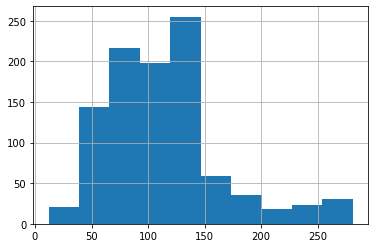

In [136]:
dataset['text'].str.len().hist()

#### No. of words by each line

<AxesSubplot:>

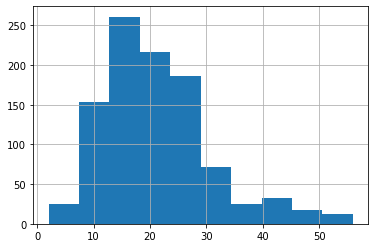

In [137]:
dataset['text'].str.split().\
    map(lambda x: len(x)).\
    hist()

#### Average word length

<AxesSubplot:>

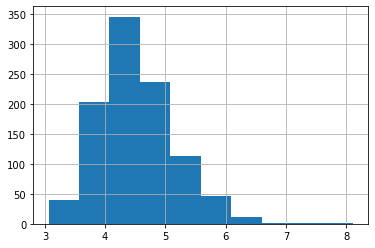

In [138]:
dataset['text'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

## Data preprocessing

In [72]:


data_list =[]
data_list2 =[]

raw_text =""
stop_words = tuple(set(stopwords.words("english")))

def lemmatization(token_sentence):
    res = []
    for word in token_sentence:
        lemmatizer.lemmatize(word)
        res.append(word)
    return res


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


# Simple test
def input_test(classifier):
    sample_text = input("Enter joke: ")
    sample_text = re.sub('[^a-zA-Z]', ' ', sample_text).lower().split()
    sample_text = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in sample_text])
    X = vectorizer.transform([sample_text]).toarray()

    print(X.shape)
    print(X)

    if(classifier.predict(X) == [1]):
        print("It's a joke! (+)")
    else:
        print("It's not a joke! (-)")

# range = dataset range
for i in range(0,dataset.shape[0]):
    
   humor_sentence = dataset['text'][i]

   #Tokenization by words or sentences
   humor_sentence = word_tokenize(humor_sentence)
   #remove stopwords and lemmatization with pos_tag
   humor_sentence = " ".join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in humor_sentence if word not in set(stopwords.words('english'))])  
  
      
   # remove alpha chars/not alphabetical caracters 
   humor_sentence2 = re.sub('[^a-zA-Z]', ' ', dataset['text'][i])
   
   humor_sentence2 = humor_sentence2.lower()
   humor_sentence2 = word_tokenize(humor_sentence2)
   humor_sentence2 = " ".join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in humor_sentence2 if word not in set(stopwords.words('english'))])  
      
   #raw_text += aux_reader+ "\n"
   
    
   # aggregate all the rows of the dataset in one corpus ('data_list')
   data_list.append(humor_sentence)
    
    # how data_list2 is different from data_list?
   data_list2.append(humor_sentence2) 


## Extract features from data

In [73]:

# Create bag-of-words model
from sklearn.feature_extraction.text import CountVectorizer


vectorizer = CountVectorizer(max_features = 8000)
X = vectorizer.fit_transform(data_list).toarray() # no. of features per phrase (phrase=X[row])
y = dataset.iloc[:,2].values


print(vectorizer.get_feature_names())
print(X.shape, y.shape)

['10', '100', '1000', '100ft', '106', '12', '1200', '1313', '14', '15', '18', '1861', '1940', '1948', '1984', '1st', '20', '2000', '2018', '2052', '2125', '22', '25', '30', '31', '3629', '365', '3d', '3rd', '40', '40th', '45', '48', '50', '500', '666', '70', '72', '75', '80', '85', '911', '999', 'aaaaafddasfrwe', 'abc', 'able', 'aboard', 'abroad', 'absent', 'absolutely', 'abuse', 'abuzz', 'accident', 'accidentally', 'accord', 'account', 'accountable', 'accuse', 'accuses', 'acquire', 'across', 'act', 'activity', 'actual', 'actually', 'ad', 'add', 'addict', 'address', 'adjust', 'admit', 'adopt', 'adult', 'adversity', 'advertisement', 'advice', 'aed', 'af', 'affect', 'afford', 'afraid', 'africa', 'african', 'after', 'age', 'agency', 'ago', 'ahead', 'ai', 'aid', 'aids', 'air', 'airline', 'airplane', 'airpod', 'ajar', 'album', 'alcohol', 'ale', 'alert', 'algae', 'alive', 'all', 'allah', 'allow', 'alone', 'alpha', 'already', 'alright', 'also', 'always', 'alzheimer', 'am', 'ama', 'amaze', 'am

## Split dataset into training and test sets

In [74]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(492, 2615) (492,)
(124, 2615) (124,)


## Generate metrics

In [75]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def print_metrics(y_test, y_pred):
    # confusion matrix
    print(confusion_matrix(y_test, y_pred))

    # accuracy
    print('Accuracy: ', accuracy_score(y_test, y_pred))

    # precision
    print('Precision: ', precision_score(y_test, y_pred))

    # recall
    print('Recall: ', recall_score(y_test, y_pred))

    # f1
    print('F1: ', f1_score(y_test, y_pred))

## Text Classification

In [76]:

# Fit Naive Bayes to the training set

from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predict test set results
y_pred = classifier.predict(X_test)

print(y_pred)
print_metrics(y_test, y_pred)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[124]]
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1:  1.0


In [78]:
input_test(classifier)


Enter joke: 'Trabajo,' the Spanish word for work, comes from the Latin term 'trepaliare,' meaning torture.
(1, 2615)
[[0 0 0 ... 0 0 0]]
It's a joke! (+)


In [57]:
# SVM

from sklearn.svm import SVC

classifier = SVC()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print_metrics(y_test, y_pred)

[[ 26  54]
 [  3 117]]
Accuracy:  0.715
Precision:  0.6842105263157895
Recall:  0.975
F1:  0.8041237113402062


In [25]:
input_test(classifier)

Enter joke: I once toasted the bride and groom at a Pakistani wedding. All I did was push the button on the drone
(1, 3973)
[[0 0 0 ... 0 0 0]]
It's a joke!


In [37]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print_metrics(y_test, y_pred)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

In [18]:
input_test(classifier)

Enter joke: I once toasted the bride and groom at a Pakistani wedding. All I did was push the button on the drone
(1, 3973)
[[0 0 0 ... 0 0 0]]
It's a joke!


In [19]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print_metrics(y_test, y_pred)

[[ 79  40]
 [ 33 148]]
Accuracy:  0.7566666666666667
Precision:  0.7872340425531915
Recall:  0.8176795580110497
F1:  0.8021680216802167


In [20]:
input_test(classifier)

Enter joke: I once toasted the bride and groom at a Pakistani wedding. All I did was push the button on the drone
(1, 3973)
[[0 0 0 ... 0 0 0]]
It's a joke!


In [42]:
from sklearn.neural_network import BernoulliRBM
lassifier = BernoulliRBM()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print_metrics(y_test, y_pred)

[[ 26  54]
 [  3 117]]
Accuracy:  0.715
Precision:  0.6842105263157895
Recall:  0.975
F1:  0.8041237113402062


In [31]:
input_test(classifier)

Enter joke: I once toasted the bride and groom at a Pakistani wedding. All I did was push the button on the drone
(1, 3973)
[[0 0 0 ... 0 0 0]]
It's a joke! (+)
